# Practical Example

The practical example consists of the stable space estimation for a multivariate time series that contains the information for several economic indicators associated with the inflation in Mexico on the period from 

In [1]:
# packages
remove(list = ls())
options(warn = -1)
library(data.table)
library(magrittr)
library(ggplot2)
library(xtable)
suppressMessages(library(GGally))

source("../source/simulations.R")
source("../source/vectorial_methods.R")
source("../source/auxiliar_methods.R")

In [2]:
getwd()

[1] "/home/robervz22/Documents/Lancaster/Paper_1/code/notebooks"

## Economic variables associated with the inflation in Mexico

In [3]:
# Variables Inflacion
dt_inflation <- data.table::fread("../databases/variables_inflation.csv")

Variables description:

- P: National Consumer Price Index
- U: Unemployment Rate
- BYM: Banknotes and Coins
- E: Nominal Exchange Rate
- R: 28-Day Interbank Interest Rate
- W: Real Wages
- PUSA: United States National Consumer Price Index 

First, we analise the covariance structure

In [4]:
options(repr.plot.width = 6, repr.plot.height =6)

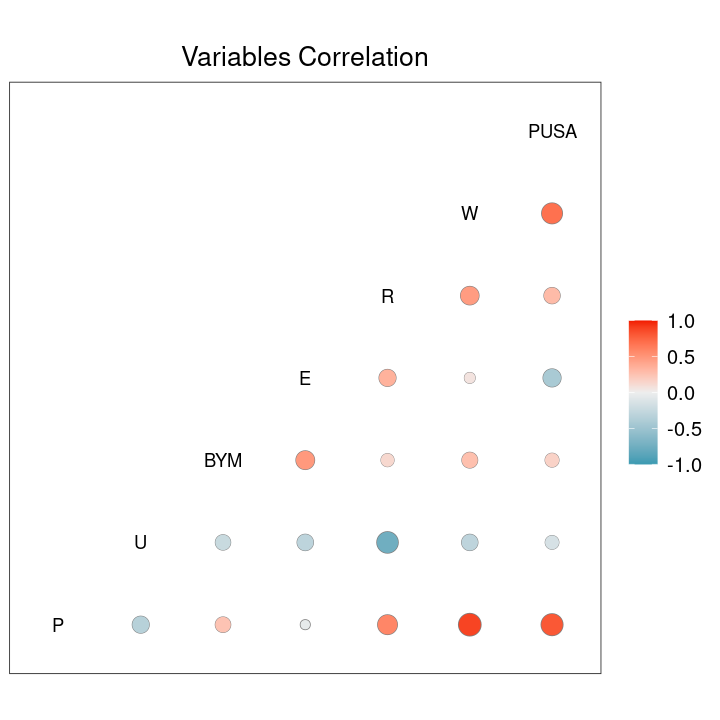

In [5]:
GGally::ggcorr(dt_inflation[,-c(1)],geom = "circle")+ggplot2::ggtitle("Variables Correlation")+mytheme

We centered the columns of the series, and we get the auxiliary blocks for the methods

In [6]:
X_inflation <- as.matrix(dt_inflation, rownames = "Date")
rownames(X_inflation) <- NULL
#X_inflation <- t(t(X_inflation) - colMeans(X_inflation))
X_inflation <- scale(X_inflation,scale = FALSE)
X_inflation <- ts(X_inflation)
XX_inflation <- X_inflation[1:(nrow(X_inflation)-1),]
Y_inflation <- X_inflation[2:nrow(X_inflation),]

We check the order of integration of each variable and print the KPSS' p-value associated.

In [7]:
I0_variables <- apply(X_inflation,2,function(x) tseries::kpss.test(x)$p.value)
I1_variables <- apply(diff(X_inflation),2,function(x) tseries::kpss.test(x)$p.value)
I2_variables <- apply(diff(diff(X_inflation)),2,function(x) tseries::kpss.test(x)$p.value)

# Example list with named vectors
list <- list(X = I0_variables, DX = I1_variables,
             DDX = I2_variables)

# Convert to data frame with row names
mat_order <- do.call(cbind, list)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [8]:
print(xtable(mat_order))

% latex table generated in R 4.1.2 by xtable 1.8-4 package
% Tue May 20 14:04:20 2025
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \hline
 & X & DX & DDX \\ 
  \hline
P & 0.01 & 0.01 & 0.10 \\ 
  U & 0.02 & 0.10 & 0.10 \\ 
  BYM & 0.10 & 0.10 & 0.10 \\ 
  E & 0.09 & 0.10 & 0.10 \\ 
  R & 0.02 & 0.04 & 0.10 \\ 
  W & 0.01 & 0.01 & 0.10 \\ 
  PUSA & 0.06 & 0.02 & 0.10 \\ 
   \hline
\end{tabular}
\end{table}


We estimate the stable space for this multivariate time series using the methods
- Johansen
- PCA
- PLS

In [9]:
basis_inflation_PLS <- basis_stable(X_inflation, method = "pls")
basis_inflation_PCA <- basis_stable(XX_inflation,method="pca")
basis_inflation_johansen <- basis_stable(XX_inflation,method = "johansen")

We visualise the weights for each methodology

In [10]:
options(repr.plot.width = 9, repr.plot.height = 6)

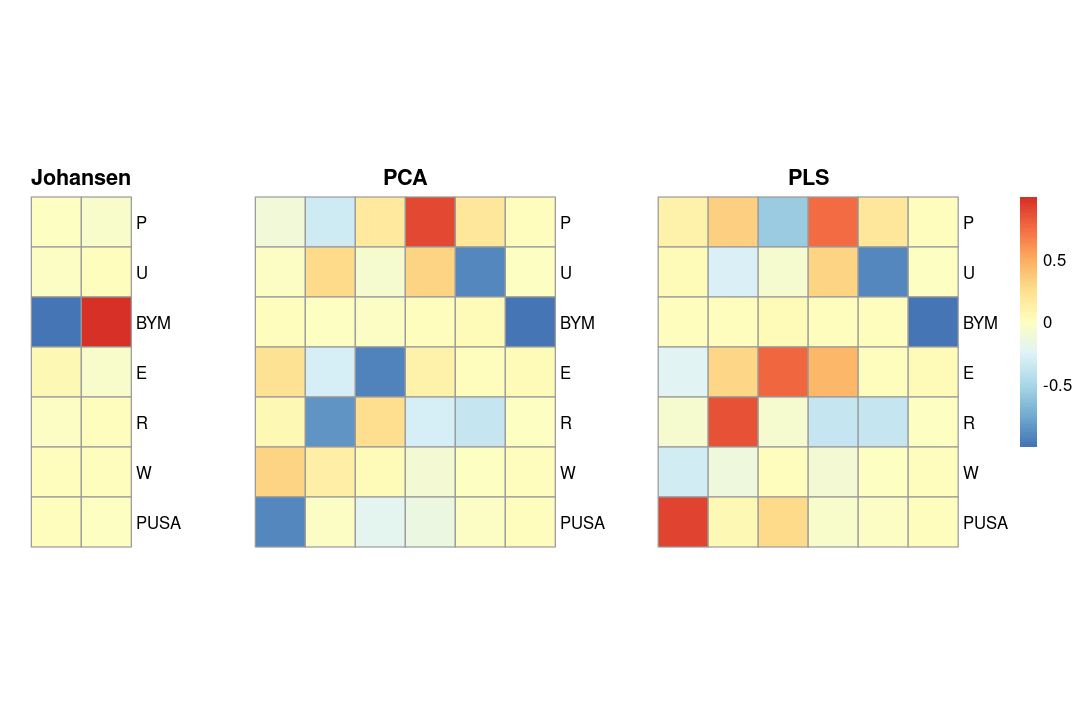

In [11]:
# Tables
table_inflation_PLS <- as.matrix(basis_inflation_PLS$weights_S)
table_inflation_PCA <- as.matrix(basis_inflation_PCA$basis_S)
table_inflation_johansen <- as.matrix(basis_inflation_johansen$basis_S)
rownames(table_inflation_PLS) <- colnames(X_inflation)
rownames(table_inflation_PCA) <- colnames(X_inflation)
rownames(table_inflation_johansen) <- colnames(X_inflation)

# Compute a common color scale range
min_value <- min(table_inflation_PLS, table_inflation_PCA, table_inflation_johansen)
max_value <- max(table_inflation_PLS, table_inflation_PCA, table_inflation_johansen)

# Define color palette
color_palette <- colorRampPalette(rev(RColorBrewer::brewer.pal(9, "RdYlBu")))(100)

# Generate heatmaps with common limits
gg_map_PLS <- pheatmap::pheatmap(table_inflation_PLS, cluster_rows = FALSE, cluster_cols = FALSE,
    cellwidth = 30, cellheight = 30, silent = TRUE, main = "PLS", color = color_palette,
    breaks = seq(min_value, max_value, length.out = 101))

gg_map_PCA <- pheatmap::pheatmap(table_inflation_PCA, cluster_rows = FALSE, cluster_cols = FALSE,
    cellwidth = 30, cellheight = 30, silent = TRUE, main = "PCA", color = color_palette,
    breaks = seq(min_value, max_value, length.out = 101), legend = FALSE)

gg_map_johansen <- pheatmap::pheatmap(table_inflation_johansen, cluster_rows = FALSE, 
    cluster_cols = FALSE, cellwidth = 30, cellheight = 30, silent = TRUE, main = "Johansen", 
    color = color_palette, breaks = seq(min_value, max_value, length.out = 101),legend = FALSE)

# Combine plots
cowplot::plot_grid(gg_map_johansen[[4]], gg_map_PCA[[4]], gg_map_PLS[[4]], 
    nrow = 1, rel_widths = c(0.25, 0.5, 0.5))


## Projection Error

As in the simulation study, we quantify the projection error to the estimated stable space

In [12]:
# PLS
T_scores_PLS <- basis_inflation_PLS$stable_scores 
Y_est_PLS <- scores_rebuilt(XX_inflation,T_scores_PLS[,1:2],Y = Y_inflation)

# PCA
T_scores_PCA <- XX_inflation%*%basis_inflation_PCA$basis_S
Y_est_PCA <- scores_rebuilt(XX_inflation,T_scores_PCA[,1:2],Y=Y_inflation)

# Johansen
T_scores_johansen <- XX_inflation%*%basis_inflation_johansen$basis_S
Y_est_johansen <- scores_rebuilt(XX_inflation,T_scores_johansen[,1:2], Y = Y_inflation)

Similarly, we could visualise the error or the time series studied

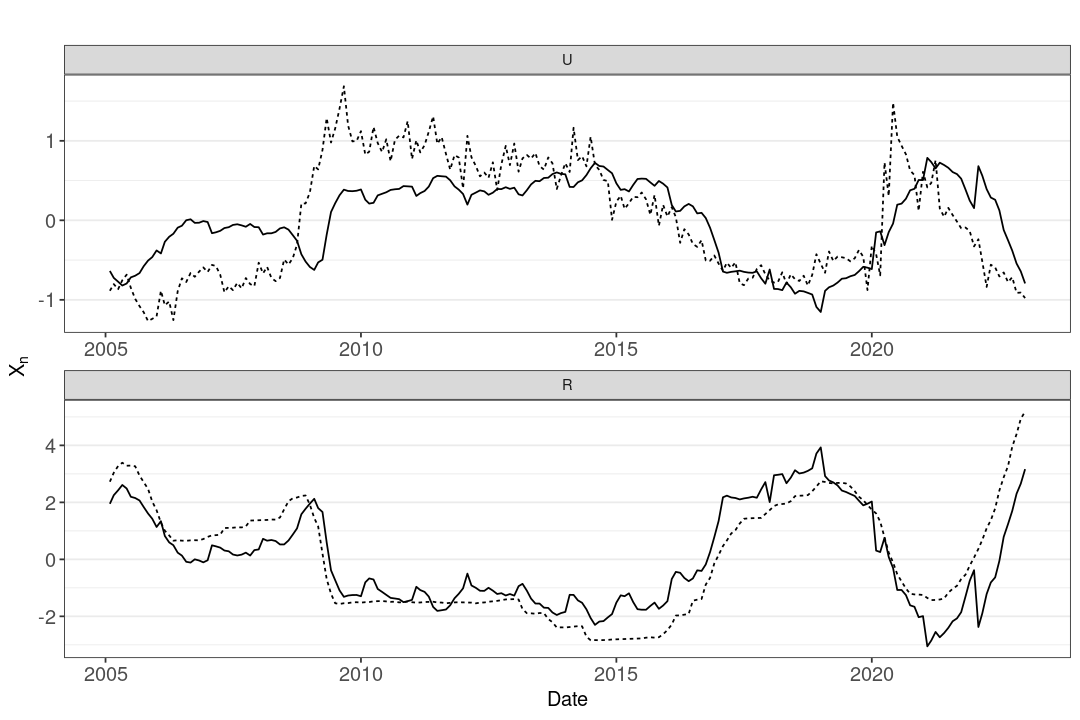

In [13]:
dates <- dt_inflation[,Date][2:nrow(dt_inflation)]
cols_selected <- c("U","R")
vis2series(Y_est_PCA$est[,cols_selected],Y_inflation[,cols_selected],dates=dates,lab_X = "obs",lab_Y = "est",
                                                                    legend.position = "none",ncol=1)

The numerical summary of the projection error is

In [14]:
MSE <- matrix(0,ncol(Y_inflation),3) 
colnames(MSE) <- c("Johansen","PCA","PLS") ; rownames(MSE) <- colnames(Y_inflation)

# error estimation
MSE[,"PLS"] <- VNMSE_(Y_inflation,Y_est_PLS$est)
MSE[,"PCA"] <- VNMSE_(Y_inflation,Y_est_PCA$est)
MSE[,"Johansen"] <- VNMSE_(Y_inflation,Y_est_johansen$est)

We print the results for the article

In [15]:
print(xtable(MSE,digits = 3))

% latex table generated in R 4.1.2 by xtable 1.8-4 package
% Tue May 20 14:04:21 2025
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \hline
 & Johansen & PCA & PLS \\ 
  \hline
P & 0.988 & 0.903 & 0.904 \\ 
  U & 0.992 & 0.541 & 0.538 \\ 
  BYM & 0.963 & 0.978 & 0.979 \\ 
  E & 0.804 & 0.390 & 0.390 \\ 
  R & 0.914 & 0.245 & 0.244 \\ 
  W & 0.859 & 0.990 & 0.990 \\ 
  PUSA & 0.990 & 0.585 & 0.586 \\ 
   \hline
\end{tabular}
\end{table}


As an extra, visualisation of the observed time series

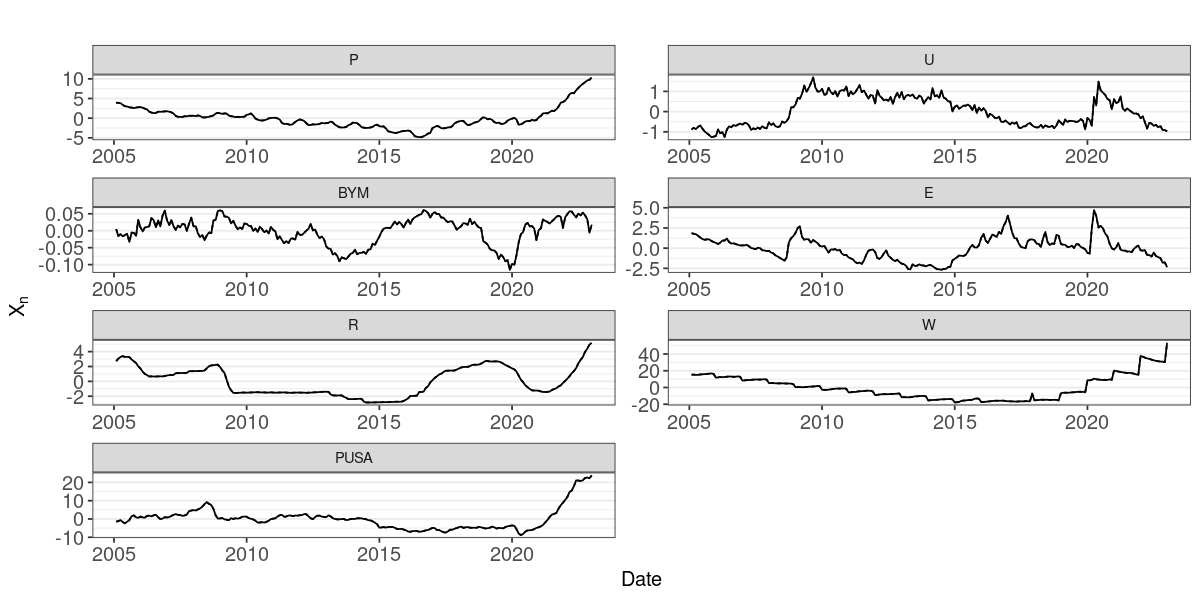

In [16]:
options(repr.plot.width = 10, repr.plot.height = 5) # plots width and heigth
dates <- dt_inflation[,Date][2:nrow(dt_inflation)]
vis2series(Y_inflation,Y_inflation,dates=dates,lab_X = "obs",lab_Y = "est",
                                                                    legend.position = "none",ncol=2)